In [1]:
import src.dependencies.injector as sdi
from src.shared.logger_factory import LoggerFactory
from src.process.data_cleaning.data_cleaning_distributions import jaccard_similarity
from src.shared.utils import get_project_root
from src.model.local_neighbourhood import LocalNeighbourhood
# Just for type signatures
from typing import List
from src.model.user import User
from src.model.social_graph.social_graph import SocialGraph
from src.model.cluster import Cluster
import argparse
import numpy as np

log = LoggerFactory.logger(__name__)
DEFAULT_PATH = str(get_project_root()) + \
    "/src/scripts/config/create_social_graph_and_cluster_config.yaml"

In [2]:
injector = sdi.Injector.get_injector_from_file(DEFAULT_PATH)
process_module = injector.get_process_module()
dao_module = injector.get_dao_module()
user_activity_getters = {
    "friends": dao_module.get_user_activity_getter(user_activity="friends"),
    "user retweets": dao_module.get_user_activity_getter(user_activity="user retweets"),
    "user retweets ids": dao_module.get_user_activity_getter(user_activity="user retweets ids")
}
user_getter = dao_module.get_user_getter()
user_friend_getter = dao_module.get_user_friend_getter()

def get_user_activities(user_id: str, user_activity: str):
    return user_activity_getters[user_activity].get_user_activities(user_id)

In [3]:
def compute_activity_similarity(user1: str, user2: str, user_activity: str):
    user1_activity = get_user_activities(user1, user_activity)
    user2_activity = get_user_activities(user2, user_activity)
    if user1_activity and user2_activity:
        # log.info(f"Computing similarity between {user1} and {user2} with length {len(user1_activity)} and {len(user2_activity)}")
        return jaccard_similarity(user1_activity, user2_activity)
    return 0

def compute_retweeted_friends_similarity(user1: str, user2: str):
    user1_retweeted_users = get_user_activities(user1, "user retweets")
    user2_retweeted_users = get_user_activities(user2, "user retweets")
    user1_friends = user_friend_getter.get_user_friends_ids(user1)
    user2_friends = user_friend_getter.get_user_friends_ids(user2)
    user1_retweeted_friends = list(set(user1_retweeted_users).intersection(set(user1_friends)))
    user2_retweeted_friends = list(set(user2_retweeted_users).intersection(set(user2_friends)))
    return jaccard_similarity(user1_retweeted_friends, user2_retweeted_friends) if user1_retweeted_friends and user2_retweeted_friends else 0

In [4]:
# Clean users function from local_neighbourhood_downloader.py
def clean_user_friends_global(user_id, friends_list):
    user = user_getter.get_user_by_id(str(user_id))
    log.info("Cleaning Friends List by Follower and Friend")
    t = 0.1

    num_users = len(friends_list)
    clean_friends_list = friends_list
    while (num_users > 1000):
        num_users = len(friends_list)
        clean_friends_list = []
        follower_thresh = t * user.followers_count
        friend_thresh = t * user.friends_count
        print(
            f"Data cleaning with thresholds {follower_thresh, friend_thresh}")
        for id in friends_list:
            num_users -= 1
            curr_user = user_getter.get_user_by_id(id)
            if user is not None and curr_user is not None and curr_user.followers_count > follower_thresh and curr_user.friends_count > friend_thresh:
                clean_friends_list.append(id)
                num_users += 1
        log.info(
            f"Increasing Data Cleaning Strength {t}, {num_users} remaining users")
        t += 0.05
    return clean_friends_list, t

In [5]:
def compare_user_friends(seed_user_name: str, activity1: str, activity2: str, activity_1_thresh: float, clean: bool = True):
    user = user_getter.get_user_by_screen_name(seed_user_name)
    seed_user = str(user.id)
    # Get user friends
    friends_map = {}
    sim_map = {}
    user_friends = user_friend_getter.get_user_friends_ids(seed_user)
    log.info(f"Seed user {seed_user} has {len(user_friends)} friends")
    if clean:
        user_friends, _ = clean_user_friends_global(seed_user, user_friends)

    for i, user1 in enumerate(user_friends):
        friends_map[user1] = []
        sim_map[user1] = 0
        if i % 50 == 0:
            log.info(f"Processing user {i} out of {len(user_friends)}")
        for user2 in user_friends:
            if user1 != user2:
                sim = compute_activity_similarity(user1, user2, activity1)
                if sim >= activity_1_thresh:
                    friends_map[user1].append(user2)
                    # If activity1 sim above threshold, check activity2
                    sim2 = compute_activity_similarity(user1, user2, activity2)
                    # log.info(f"Similarity between {user1} and {user2} in activity {activity2} is {sim2}")
                    sim_map[user1] += sim2
                    
                    # If activity1 = 'friends', we can also check retweeted friends
                    # sim2 = compute_retweeted_friends_similarity(user1, user2)
                    # log.info(f"Similarity between {user1} and {user2} in retweeted friends is {sim2}")
                    # sim_map[user1] += compute_retweeted_friends_similarity(user1, user2)
        
        # Obtain average similarity
        if len(friends_map[user1]) > 0:
            sim_map[user1] /= len(friends_map[user1])
        
        # Sort sim_map by decreasing similarity
        sim_map = {k: v for k, v in sorted(sim_map.items(), key=lambda item: item[1], reverse=True)}

    return friends_map, sim_map

In [6]:
def compare_retweeted_and_friends(user_name: str):
    user = user_getter.get_user_by_screen_name(user_name)
    user_id = str(user.id)
    # Get user friends
    user_friends = user_friend_getter.get_user_friends_ids(user_id)
    user_retweeted_users = get_user_activities(user_id, "user retweets")
    user_retweeted_friends = list(set(user_retweeted_users).intersection(set(user_friends)))

    # Return ratios
    if len(user_friends) == 0:
        return 0, 0
    elif len(user_retweeted_users) == 0:
        return len(user_retweeted_friends) / len(user_friends), 0
    return len(user_retweeted_friends) / len(user_friends), len(user_retweeted_friends) / len(user_retweeted_users), len(user_retweeted_users) / len(user_friends)

In [15]:
username = "chessable"

rtff, rtfrtu, rtuf = compare_retweeted_and_friends(username)
log.info(f"Retweeted friends ratio: {rtff}")
log.info(f"Retweeted friends to retweeted users ratio: {rtfrtu}")
log.info(f"Retweeted users to friends ratio: {rtuf}")
# hardmaru: friends - 0.2, retweets - 0.05
start_thresh = 0.3
end_thresh = 0.5
# Split into 5 thresholds
thresholds = np.linspace(start_thresh, end_thresh, 5)
log.info(f"Thresholds: {thresholds}")
avg_sims = []
for thresh in thresholds:
    log.info(f"Running with threshold: {thresh}")
    friends_map, sim_map = compare_user_friends(username, "friends", "user retweets", thresh)
    log.info(f"Similarity map: {str(sim_map)}")

    # Filter sim_map, keys with non-zero values
    filtered_sim_map = {k: v for k, v in sim_map.items() if v > 0}
    log.info(f"Similarity map - non-zero similarity: {str(filtered_sim_map)}")

    friend_count = len([k for k, v in friends_map.items() if len(v) > 0])

    log.info(f"Number of friends: {friend_count}")

    # Average similarity
    avg_sim = sum(sim_map.values()) / friend_count
    log.info(f"Average similarity for threshold={thresh} is: {avg_sim}")
    avg_sims.append(avg_sim)

2023-06-05 01:11:13 - __main__ - INFO - Retweeted friends ratio: 0.09239130434782608
2023-06-05 01:11:13 - __main__ - INFO - Retweeted friends to retweeted users ratio: 0.45169082125603865
2023-06-05 01:11:13 - __main__ - INFO - Retweeted users to friends ratio: 0.20454545454545456
2023-06-05 01:11:13 - __main__ - INFO - Thresholds: [0.1  0.15 0.2  0.25 0.3 ]
2023-06-05 01:11:13 - __main__ - INFO - Running with threshold: 0.1
2023-06-05 01:11:13 - __main__ - INFO - Seed user 4369711156 has 2024 friends
2023-06-05 01:11:13 - __main__ - INFO - Cleaning Friends List by Follower and Friend


Data cleaning with thresholds (3003.0, 202.20000000000002)


2023-06-05 01:11:20 - __main__ - INFO - Increasing Data Cleaning Strength 0.1, 297 remaining users
2023-06-05 01:11:20 - __main__ - INFO - Processing user 0 out of 297
2023-06-05 01:22:23 - __main__ - INFO - Processing user 50 out of 297
2023-06-05 01:26:42 - __main__ - INFO - Processing user 100 out of 297
2023-06-05 01:36:37 - __main__ - INFO - Processing user 150 out of 297
2023-06-05 01:50:01 - __main__ - INFO - Processing user 200 out of 297
2023-06-05 01:56:04 - __main__ - INFO - Processing user 250 out of 297
2023-06-05 02:00:23 - __main__ - INFO - Similarity map: {182441567: 0.021699660474346013, 172426690: 0.01697260198539374, 228806806: 0.015886211702495524, 60995997: 0.015852390852390853, 449588356: 0.015852390852390853, 32022439: 0.01477021865386596, 425376095: 0.012159167782484747, 93036245: 0.011557331601708533, 853648277396475904: 0.009708737864077669, 572058278: 0.008168130778183427, 1588889406: 0.00808951908719015, 92284830: 0.0074225168208749874, 94340676: 0.007329840

Data cleaning with thresholds (3003.0, 202.20000000000002)


2023-06-05 02:00:32 - __main__ - INFO - Increasing Data Cleaning Strength 0.1, 297 remaining users
2023-06-05 02:00:32 - __main__ - INFO - Processing user 0 out of 297
2023-06-05 02:03:34 - __main__ - INFO - Processing user 50 out of 297
2023-06-05 02:05:29 - __main__ - INFO - Processing user 100 out of 297
2023-06-05 02:07:46 - __main__ - INFO - Processing user 150 out of 297
2023-06-05 02:10:58 - __main__ - INFO - Processing user 200 out of 297
2023-06-05 02:13:09 - __main__ - INFO - Processing user 250 out of 297
2023-06-05 02:14:47 - __main__ - INFO - Similarity map: {94340676: 0.03510060214422089, 249601765: 0.03211542936932744, 182441567: 0.02824797493929452, 172426690: 0.026443033084300488, 92244436: 0.02452316076294278, 228806806: 0.023601954165785317, 313299656: 0.021236286113235147, 384764469: 0.020919572030384706, 92284830: 0.02091327705295472, 75174049: 0.019599666388657216, 1588889406: 0.018951497436285342, 1884178352: 0.018819503849443968, 20745074: 0.016384546271338726, 

Data cleaning with thresholds (3003.0, 202.20000000000002)


2023-06-05 02:14:57 - __main__ - INFO - Increasing Data Cleaning Strength 0.1, 297 remaining users
2023-06-05 02:14:57 - __main__ - INFO - Processing user 0 out of 297
2023-06-05 02:16:25 - __main__ - INFO - Processing user 50 out of 297
2023-06-05 02:17:42 - __main__ - INFO - Processing user 100 out of 297
2023-06-05 02:18:48 - __main__ - INFO - Processing user 150 out of 297
2023-06-05 02:19:56 - __main__ - INFO - Processing user 200 out of 297
2023-06-05 02:21:25 - __main__ - INFO - Processing user 250 out of 297
2023-06-05 02:22:54 - __main__ - INFO - Similarity map: {3026351601: 0.10968156963653908, 384764469: 0.10968156963653908, 249601765: 0.03211542936932744, 313299656: 0.03211542936932744, 999111329003827200: 0.028175573407847248, 1588889406: 0.027733503347146957, 228806806: 0.027733503347146957, 20745074: 0.022102425876010783, 9777022: 0.020217879604672057, 1330571318971027462: 0.02015163720651475, 1884178352: 0.018819503849443968, 83338597: 0.018819503849443968, 434270813: 0

Data cleaning with thresholds (3003.0, 202.20000000000002)


2023-06-05 02:23:02 - __main__ - INFO - Increasing Data Cleaning Strength 0.1, 297 remaining users
2023-06-05 02:23:02 - __main__ - INFO - Processing user 0 out of 297
2023-06-05 02:24:01 - __main__ - INFO - Processing user 50 out of 297
2023-06-05 02:25:11 - __main__ - INFO - Processing user 100 out of 297
2023-06-05 02:26:05 - __main__ - INFO - Processing user 150 out of 297
2023-06-05 02:27:00 - __main__ - INFO - Processing user 200 out of 297
2023-06-05 02:28:25 - __main__ - INFO - Processing user 250 out of 297
2023-06-05 02:29:50 - __main__ - INFO - Similarity map: {3026351601: 0.10968156963653908, 384764469: 0.10968156963653908, 1588889406: 0.027733503347146957, 228806806: 0.027733503347146957, 2903787894: 0.01849112426035503, 1239921577371693057: 0.01556420233463035, 2903353004: 0.014000782154178349, 1617972740: 0.013337779259753251, 132702118: 0.013337779259753251, 3086225424: 0.007947019867549669, 9777022: 0, 917892794953404417: 0, 301042394: 0, 20745074: 0, 65563673: 0, 2115

Data cleaning with thresholds (3003.0, 202.20000000000002)


2023-06-05 02:30:00 - __main__ - INFO - Increasing Data Cleaning Strength 0.1, 297 remaining users
2023-06-05 02:30:00 - __main__ - INFO - Processing user 0 out of 297
2023-06-05 02:30:54 - __main__ - INFO - Processing user 50 out of 297
2023-06-05 02:32:02 - __main__ - INFO - Processing user 100 out of 297
2023-06-05 02:32:53 - __main__ - INFO - Processing user 150 out of 297
2023-06-05 02:33:47 - __main__ - INFO - Processing user 200 out of 297
2023-06-05 02:35:13 - __main__ - INFO - Processing user 250 out of 297
2023-06-05 02:36:38 - __main__ - INFO - Similarity map: {3026351601: 0.10968156963653908, 384764469: 0.10968156963653908, 9777022: 0, 917892794953404417: 0, 301042394: 0, 20745074: 0, 65563673: 0, 211540535: 0, 898227168836300801: 0, 2885088400: 0, 24602126: 0, 41921185: 0, 1202405974658686976: 0, 898994539: 0, 1315598148887146498: 0, 1382709507030188037: 0, 988531805904097284: 0, 1252441094: 0, 1300150876888166401: 0, 2903353004: 0, 119006288: 0, 17266725: 0, 1197765435531

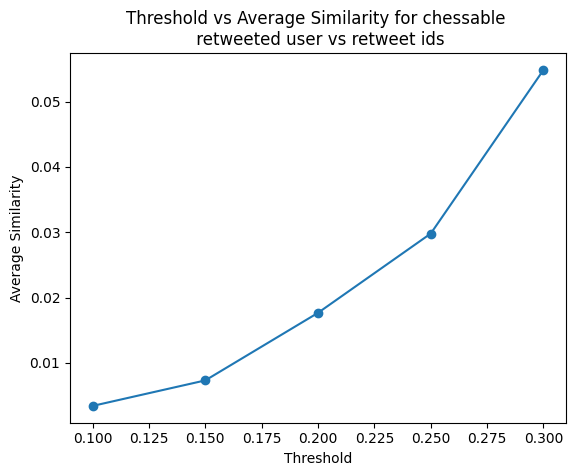

In [16]:
# Plot thresholds vs average similarity
import matplotlib.pyplot as plt
plt.plot(thresholds, avg_sims, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Average Similarity")
plt.title(f"Threshold vs Average Similarity for {username} \n friends vs retweeted users")
plt.savefig(f"threshold_vs_avg_sim_{username}-higher.png")
plt.show()